Epoch 1/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: 0.6927 - val_accuracy: 0.0000e+00 - val_loss: 0.6768
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.6112 - val_accuracy: 0.0000e+00 - val_loss: 0.2822
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.2040 - val_accuracy: 0.0000e+00 - val_loss: 0.0861
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0073 - loss: 0.0656 - val_accuracy: 0.0000e+00 - val_loss: 0.0412
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0309 - val_accuracy: 0.0000e+00 - val_loss: 0.0249

📊 Top 5 Movie Recommendations for User 1
 - Star Wars (1977): 1.00
 - Fargo (1996): 1.00
 - Contact (1997): 1.00
 - Return of the Jedi (1983): 1.00
 - English Patient, The (1996): 1.00


/tmp/ipykernel_105841/1612290001.py:85: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/adhithya/ml/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


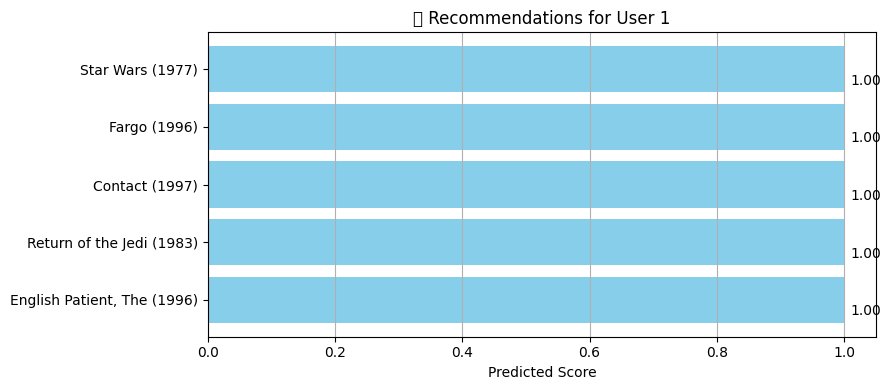


📊 Top 5 Movie Recommendations for User 5
 - Star Wars (1977): 1.00
 - Fargo (1996): 1.00
 - Contact (1997): 1.00
 - Return of the Jedi (1983): 1.00
 - Godfather, The (1972): 1.00


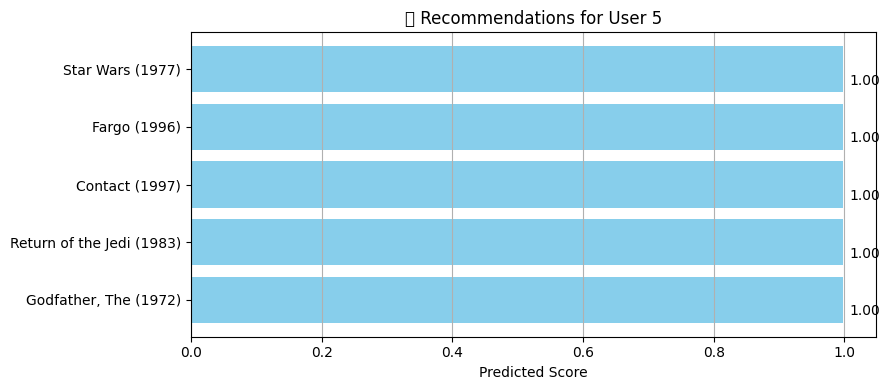


📊 Top 5 Movie Recommendations for User 10
 - Star Wars (1977): 1.00
 - Fargo (1996): 1.00
 - Contact (1997): 1.00
 - Return of the Jedi (1983): 1.00
 - Godfather, The (1972): 1.00


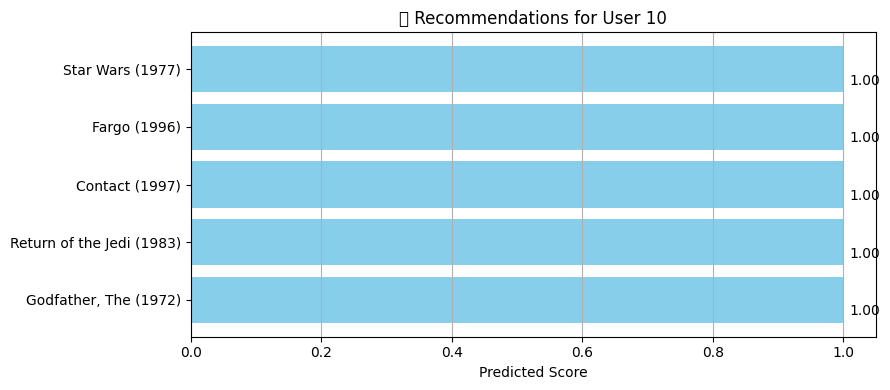


📊 Top 5 Movie Recommendations for User 50
 - Star Wars (1977): 0.99
 - Contact (1997): 0.98
 - Fargo (1996): 0.98
 - Return of the Jedi (1983): 0.98
 - Godfather, The (1972): 0.98


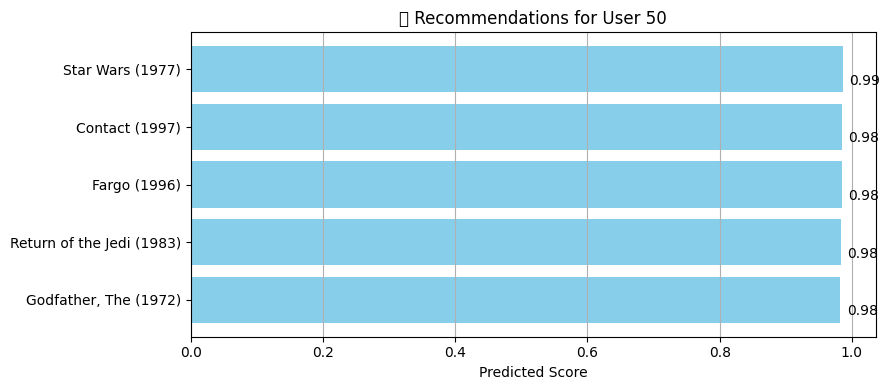


📊 Top 5 Movie Recommendations for User 100
 - Star Wars (1977): 0.99
 - Contact (1997): 0.99
 - Fargo (1996): 0.99
 - English Patient, The (1996): 0.99
 - Titanic (1997): 0.99


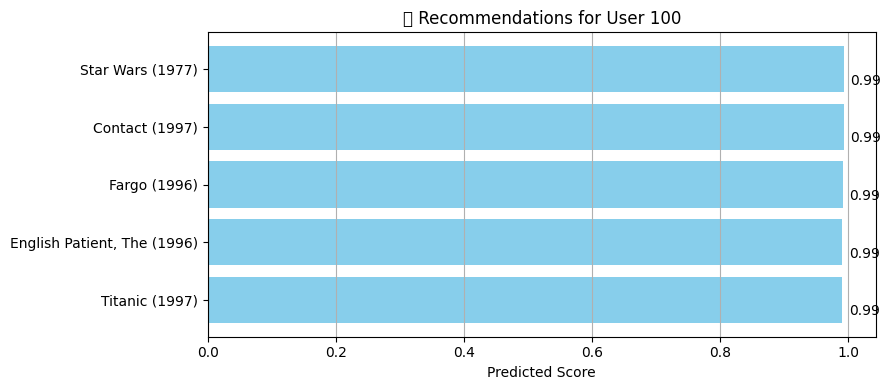

In [5]:


import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


ratings_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
movies_url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.item"

ratings_df = pd.read_csv(ratings_url, sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
movies_df = pd.read_csv(movies_url, sep="|", names=["item_id", "title"], encoding="latin-1", usecols=[0, 1])


ratings_df = ratings_df[ratings_df["rating"] >= 4]
df = ratings_df.merge(movies_df, on="item_id")


user2idx = {u: i for i, u in enumerate(df['user_id'].unique())}
item2idx = {i: j for j, i in enumerate(df['item_id'].unique())}
idx2item = {v: k for k, v in item2idx.items()}
itemid_to_title = dict(zip(movies_df.item_id, movies_df.title))

df['user'] = df['user_id'].map(user2idx)
df['item'] = df['item_id'].map(item2idx)

num_users = len(user2idx)
num_items = len(item2idx)

train, test = train_test_split(df[["user", "item"]], test_size=0.2, random_state=42)
X_train, X_test = train.to_numpy(), test.to_numpy()
y_train = np.ones(len(train))
y_test = np.ones(len(test))


class Recommender(tf.keras.Model):
    def __init__(self, num_users, num_items, embed_dim=64):
        super().__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users, embed_dim)
        self.item_embedding = tf.keras.layers.Embedding(num_items, embed_dim)

    def call(self, inputs):
        user_vec = self.user_embedding(inputs[:, 0])
        item_vec = self.item_embedding(inputs[:, 1])
        return tf.sigmoid(tf.reduce_sum(user_vec * item_vec, axis=1))

model = Recommender(num_users, num_items)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=256, validation_data=(X_test, y_test))


def recommend_for_user(raw_user_id):
    if raw_user_id not in user2idx:
        print(f"User {raw_user_id} not found in training data.")
        return

    user_id = user2idx[raw_user_id]
    user_vector = np.full((num_items,), user_id)
    item_vector = np.arange(num_items)
    pairs = np.stack((user_vector, item_vector), axis=1)

    scores = model.predict(pairs, verbose=0)
    top_indices = np.argsort(scores)[-5:][::-1]
    top_item_ids = [idx2item[i] for i in top_indices]
    top_titles = [itemid_to_title[i] for i in top_item_ids]
    top_scores = scores[top_indices]

    print(f"\n📊 Top 5 Movie Recommendations for User {raw_user_id}")
    for title, score in zip(top_titles, top_scores):
        print(f" - {title}: {score:.2f}")

    
    plt.figure(figsize=(9, 4))
    bars = plt.barh(top_titles[::-1], top_scores[::-1], color='skyblue')
    for bar, score in zip(bars, top_scores[::-1]):
        plt.text(bar.get_width() + 0.01, bar.get_y() + 0.2, f"{score:.2f}", va='center')
    plt.xlabel("Predicted Score")
    plt.title(f"🎯 Recommendations for User {raw_user_id}")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()


for uid in [1, 5, 10, 50, 100]:
    recommend_for_user(uid)
